In [1]:
#.1 Import top-level libraries

import pandas as pd #used for data frames
import numpy as np

In [2]:
#2. Download latest USAID oppty data

import requests
import time

timestr = time.strftime("%Y%m%d-%H%M%S")


dls = "https://www.usaid.gov/business-forecast/search/download/usaid-business-forecast.xlsx"
resp = requests.get(dls)
 
output = open('USAID_' + timestr + '.xlsx', 'wb')
output.write(resp.content)
output.close()

In [3]:
#3. Create data array

data = pd.read_excel('USAID_'+timestr+'.xlsx')

In [4]:
#4. Clean up column headers

data.columns = ['OperatingUnit', 'AASpecialist', 'AwardTitle', 'AwardDescription',
       'Sector', 'Code', 'AmountRange', 'Incumbent',
       'AwardActionType', 'SmallBusinessSetAside',
       'FiscalYearofAction', 'AnticipatedAwardDate_raw',
       'AnticipatedSolicitationReleaseDate_raw', 'AwardLength',
       'SolicitationNumber', 'BusinessForecastStatusChange', 'Location',
       'LastModifiedDate_raw']

In [5]:
#5. Add new columns to populate lower and upper amount range into

data['BaseAmount'] = data.AmountRange
data['CeilingAmount'] = data.AmountRange
data['AnticpatedAwardDate'] = pd.to_datetime(data.AnticipatedAwardDate_raw)
data['AnticipatedSolicitationReleaseDate'] = pd.to_datetime(data.AnticipatedSolicitationReleaseDate_raw)
data['LastModifiedDate'] = pd.to_datetime(data.LastModifiedDate_raw)


In [6]:
#6. Clean up data types

#categories
data.OperatingUnit = data.OperatingUnit.astype('category')
data.Sector = data.Sector.astype('category')
data.Location = data.Location.astype('category')
data.FiscalYearofAction = data.FiscalYearofAction.astype('category')
data.OperatingUnit = data.OperatingUnit.astype('category')
data.AmountRange = data.AmountRange.astype('category')
data.Code = data.Code.astype('category')

In [7]:
#7. Remove rows where AmountRange is null

data = data[data.AmountRange.notnull()]

In [8]:
#7. Create dictionaries for lower and upper replacements

base_replacements = {
    '$150,000 - $499,999':150000,
    '$500,000 - $999,999':500000,
    '$1M - $3.99M':1000000,
    '$4M - $9.99M':4000000,
    '$10M - $24.99M':10000000,
    '$25M - $49.99M':25000000,
    '$50M - $99.99M':50000000,
    '$100M - $299.99M':100000000,
    '$300M - $499.99M':300000000,
    '$500M - $749.99M':500000000,
    '$2B - $2.49B':2000000000,
    'NaN':0
                }

ceiling_replacements = {
    '$150,000 - $499,999':499999,
    '$500,000 - $999,999':999999,
    '$1M - $3.99M':3900000,
    '$4M - $9.99M':9999000,
    '$10M - $24.99M':24990000,
    '$25M - $49.99M':49990000,
    '$50M - $99.99M':99990000,
    '$100M - $299.99M':299990000,
    '$300M - $499.99M':499990000,
    '$500M - $749.99M':749990000,
    '$2B - $2.49B':2490000000
                }

In [9]:
#8. Make replacements and update datatypes

data['BaseAmount'].replace(base_replacements, inplace=True)
data['CeilingAmount'].replace(ceiling_replacements, inplace=True)

data.BaseAmount = data.BaseAmount.astype('float64')
data.CeilingAmount = data.CeilingAmount.astype('float64')

In [10]:
#9. Create a copy of the enriched dataset

vizdata = data.copy()

In [11]:
#9b. Write enriched dataset to a file

data.to_excel('USAID_' + timestr + '_ENRICHED.xlsx')

In [12]:
#10. Create filters as needed for viz

filter_sector = (vizdata.Sector == 'Global Health')\
                    | (vizdata.Sector == "Gender Equality and Women's Empowerment")\
                    | (vizdata.Sector == 'Working in Crises and Conflict')\
                    | (vizdata.Sector == 'Environment and Global Climate Change')\
                    | (vizdata.Sector == 'Education')
                
filter_base_under10 = vizdata.BaseAmount < 10000000
filter_base_over10 = vizdata.BaseAmount > 10000000

filter_overseas_only = vizdata.Location != 'Washington'
filter_washington_only = vizdata.Location != 'Overseas'

In [13]:
#11. Print unique values from any field in the dataset (^ great for filters ^)

for gen in vizdata.AmountRange.unique():
    print(gen)

$1M - $3.99M
$10M - $24.99M
$4M - $9.99M
$500,000 - $999,999
$25M - $49.99M
$50M - $99.99M
$150,000 - $499,999
$100M - $299.99M
$500M - $749.99M
$300M - $499.99M


In [14]:
#12. Create lists to use for custom sorting

Sector_Order = [ 'Democracy, Human Rights, and Governance', \
'Working in Crises and Conflict', \
'Agriculture and Food Security', \
'Management', \
'U.S. Global Development Lab', \
'Economic Growth and Trade', \
'Education', \
'Environment and Global Climate Change', \
'Global Health', \
'Water and Sanitation', \
"Gender Equality and Women's Empowerment"]

---

In [15]:
#Build Data Visualization

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') 

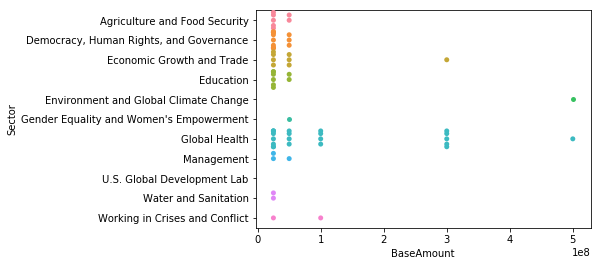

In [16]:
v1 = sns.swarmplot(data=vizdata[filter_base_over10], y='Sector', x='BaseAmount')

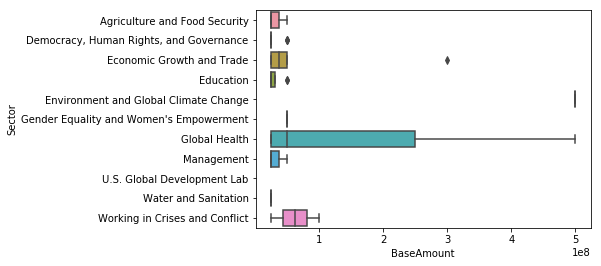

In [17]:
v2 = sns.boxplot(data=vizdata[filter_base_over10], x='BaseAmount', y='Sector')

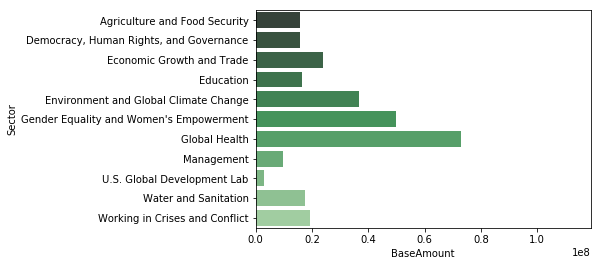

In [18]:
v3 = sns.barplot(data=vizdata, y='Sector', x='BaseAmount', palette='Greens_d',\
                errwidth=0, )

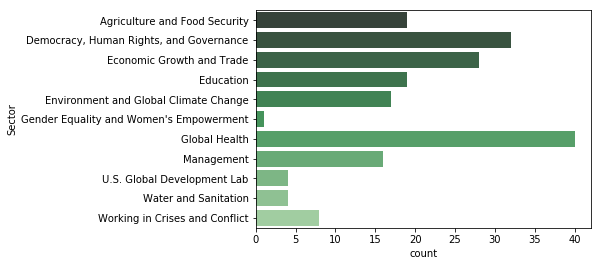

In [19]:
v4 = sns.countplot(data=vizdata, y='Sector', palette='Greens_d')

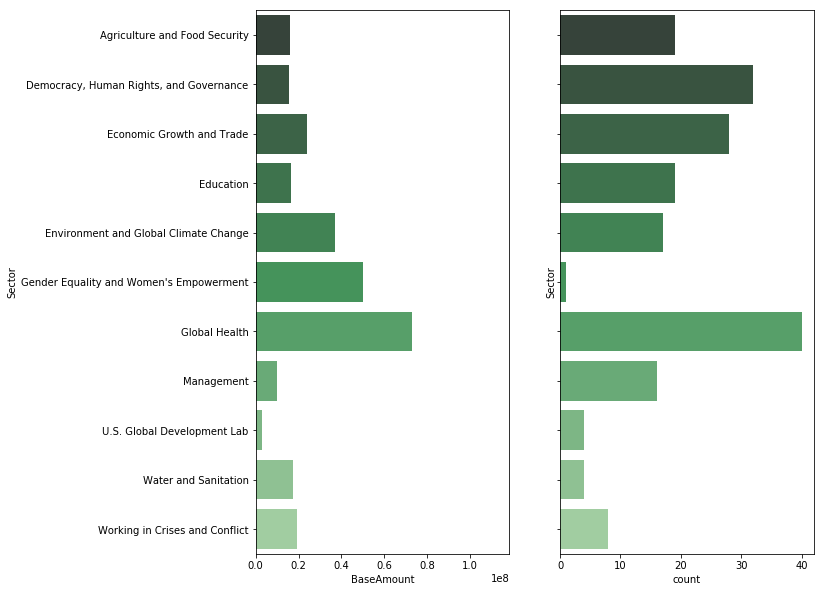

In [20]:
figure, axes = plt.subplots(1,2, figsize=(10,10),sharey=True)

#Plot[0,0]

v3 = sns.barplot(data=vizdata, y='Sector', x='BaseAmount', palette='Greens_d',\
                errwidth=0, ax=axes[0])

#Plot[0,1]

v4 = sns.countplot(data=vizdata, y='Sector', palette='Greens_d', \
                  ax=axes[1])

In [21]:
washington_base_under_10 = pd.DataFrame(vizdata[(filter_base_under10 & filter_washington_only)]\
                            .pivot_table(index="OperatingUnit",columns="Sector", values="BaseAmount"))
    
    
washington_base_over_10 = pd.DataFrame(vizdata[filter_base_over10 & filter_washington_only]\
                            .pivot_table(index="OperatingUnit",columns="Sector", values="BaseAmount"))
    

overseas_base_under_10 = pd.DataFrame(vizdata[(filter_base_under10 & filter_overseas_only)]\
                            .pivot_table(index="OperatingUnit",columns="Sector", values="BaseAmount"))
    
overseas_base_over_10 = pd.DataFrame(vizdata[filter_base_over10 & filter_overseas_only]\
                            .pivot_table(index="OperatingUnit",columns="Sector", values="BaseAmount"))

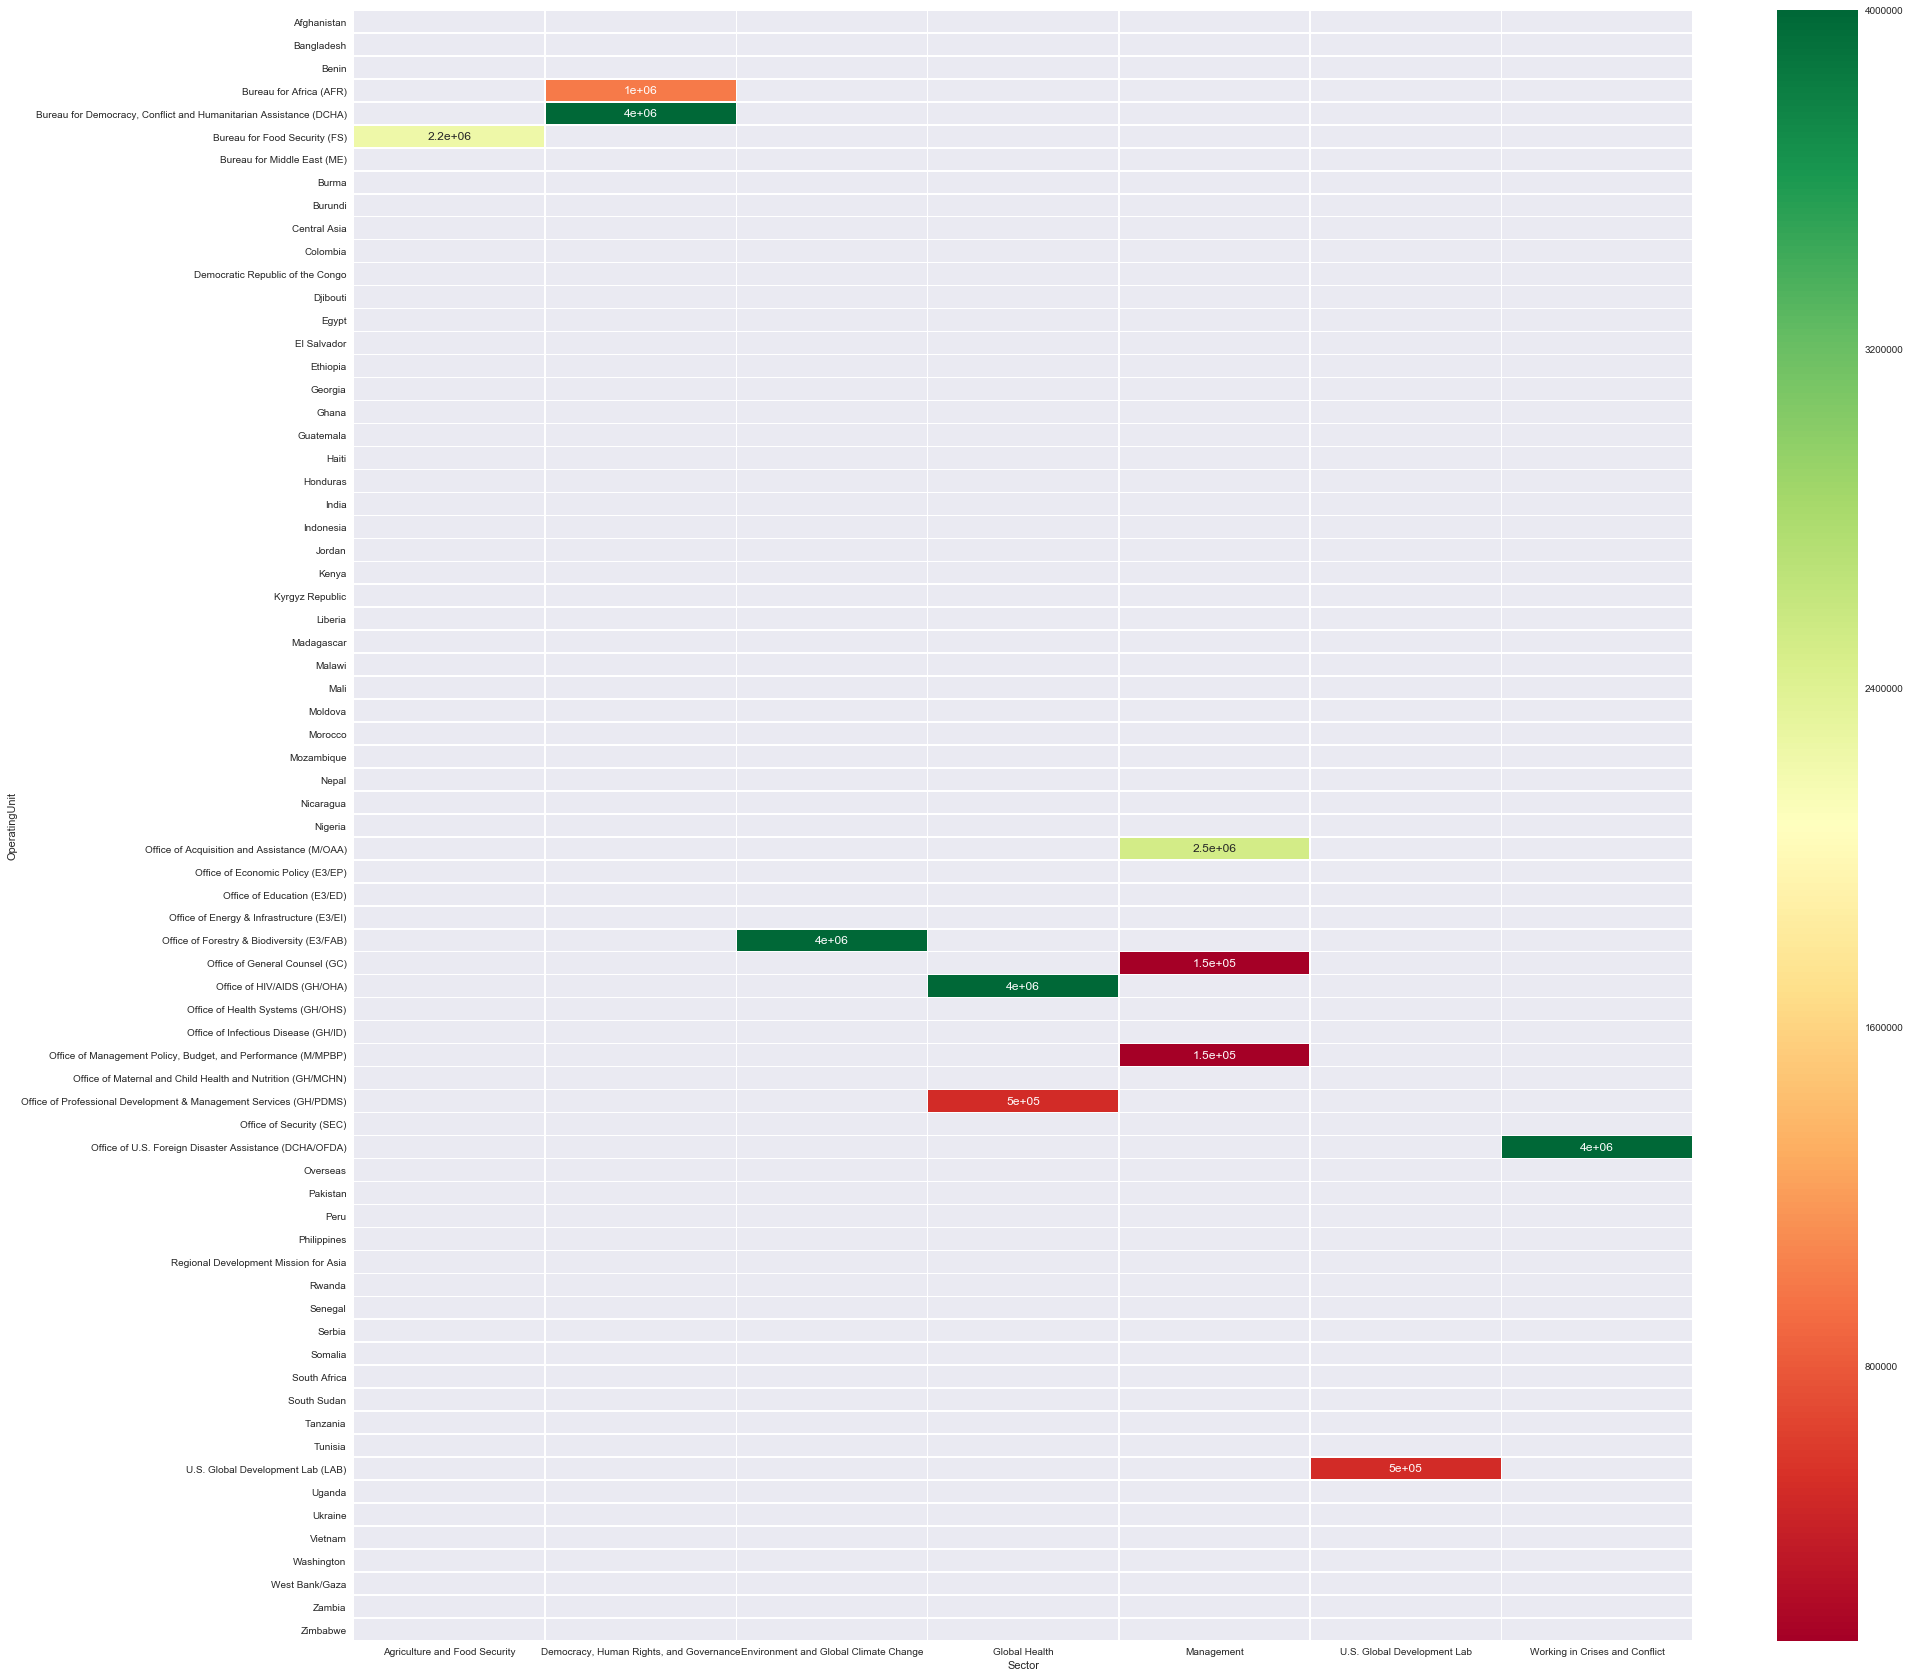

In [22]:
#set the style

sns.set(style='darkgrid', palette='muted', color_codes = True)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(30, 30))

v5 = sns.heatmap(washington_base_under_10, annot=True, linewidths=.5, ax=ax, cmap="RdYlGn")

plt.show()


No handles with labels found to put in legend.


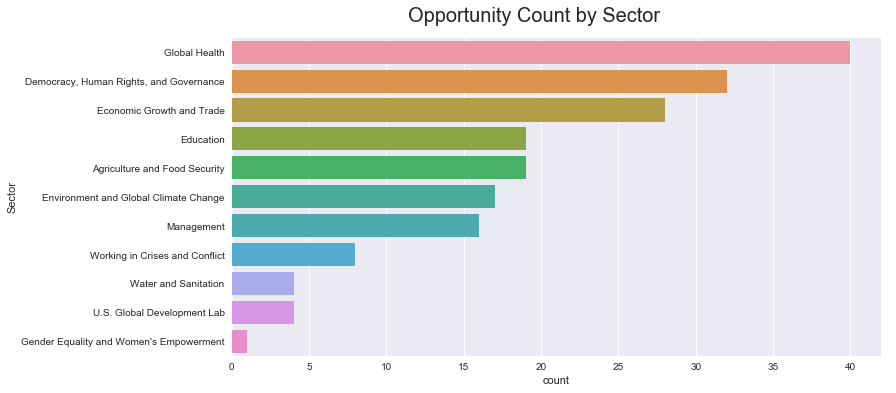

In [23]:
#set the style

sns.set(style='darkgrid', palette='muted', color_codes = True)


v7 = sns.factorplot(data=vizdata.sort_values(by='Sector'), 
                    y = 'Sector', kind='count',size=5,aspect=2.5,
                   order = vizdata['Sector'].value_counts().index)


#Access the Figure
fig = v7.fig

#Add a title to the Figure
fig.suptitle('Opportunity Count by Sector', fontsize=20, \
             **{'x':.6,'y':1.05,'horizontalalignment':'center'})

fig.legend()

#Show plot
plt.show()

In [24]:
type(v7)

seaborn.axisgrid.FacetGrid

In [25]:
import plotly.plotly as py
import plotly.graph_objs as go

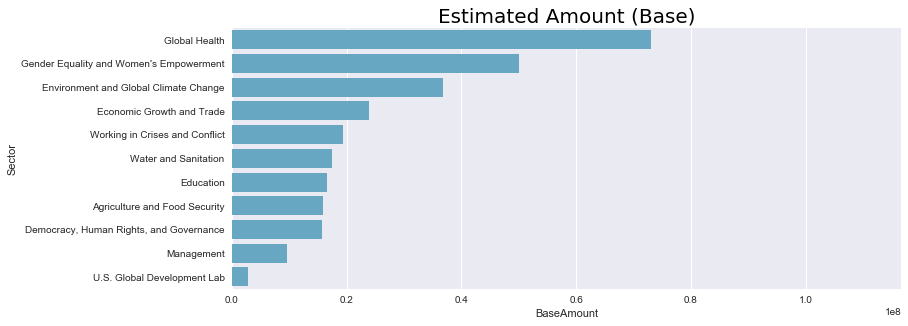

In [62]:
#set the style

sns.set(style='darkgrid', palette='muted', color_codes = False)

figure, axes = plt.subplots(figsize=(12,4.8))

#12. Create lists to use for custom sorting

Sector_Order_1 = [ 
    
'Global Health', \
"Gender Equality and Women's Empowerment", \
'Environment and Global Climate Change', \
'Economic Growth and Trade', \
'Working in Crises and Conflict', \
'Water and Sanitation', \
'Education', \
'Agriculture and Food Security', \
'Democracy, Human Rights, and Governance', \
'Management', \
'U.S. Global Development Lab']

v8 = sns.barplot(data=vizdata, x='BaseAmount', y='Sector', order=Sector_Order_1, errwidth=0, color='#58ADD1' )

#-----FORMATTING-----#
v8.set_title("Estimated Amount (Base)", fontsize=20, color='Black', fontname='Roboto')

v8.set_xlabel("Base Amount ($B)", fontsize=14, color='Black', fontname='Roboto')
v8.set_ylabel("Audience Rating", fontsize=14, color='Black', fontname='Roboto')



plt.show()